In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
pd.set_option('display.max_columns', None)

import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


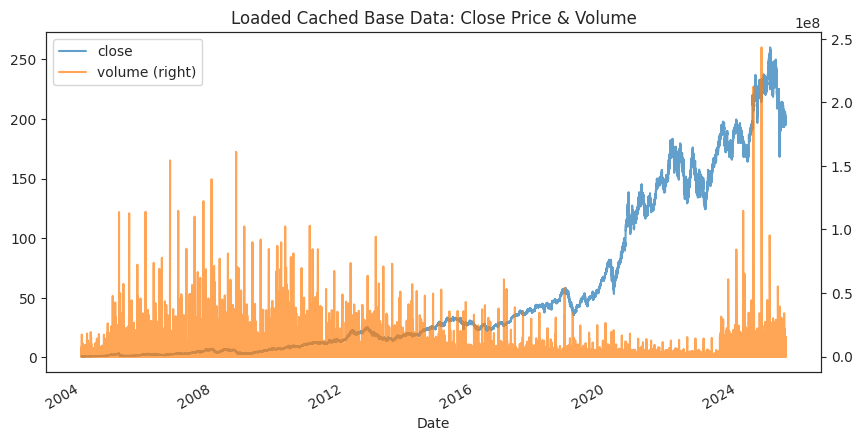

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 09:00:00     28000.0    0.764857    0.763714  
2004-01-02 09:01:00     28000.0    0.764857    0.763714  
2004-01-02 09:02:00     28000.0    0.764857    0.763714  
2004-01-02 09:03:00     28000.0    0.764857    0.763714  
2004-01-02 09:04:00     28000.0    0.764857    0.763714  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.962600  196.667400  
2025-06-18 20:57:00    460630.0  196.822500  196.527500  
2025-06-18 20:58:00    525245.0  196.817500  196.522500  
2025-06-18 20:59:00   2075503.0  196.387200  196.092800  
2025-06-18 21:00:00  15600625.0  196.687400  196.392600  

[3893400 rows x 7 columns]

In [2]:
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder              = params.stocks_folder,
        ticker              = params.ticker,
        bidasktoclose_pct   = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                = df_raw,
        sess_premark      = params.sess_premark,
        sess_start        = params.sess_start,
        sess_end          = params.sess_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
def process_single_day(day_str: str, best_optuna_params: dict):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n---------------------------------------------------------------------------------------------------------------------------------------------------\n")
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same best_optuna_params
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal', # name for the signal column to use
                                        col_action               = 'signal_action', # name for the trade-action column to add
                                        day_to_check             = day_str,
                                        **best_optuna_params            # unpack tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = best_optuna_params['buy_threshold'],
                    performance_stats  = perf_day,
                    start_plot         = params.sess_start # or sess_premark 
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [4]:
def saveDF_checkDAY(df: pd.DataFrame, best_optuna_params: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., best_optuna_params)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **best_optuna_params
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save the dataframe with the calculated signal
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass best_optuna_params into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 best_optuna_params = best_optuna_params)
        
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack best_optuna_params into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **best_optuna_params
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all


best_optuna_value: 0.6086970370370371
best_optuna_params: {'min_prof_thr': 0.013294030653931425, 'max_down_prop': 0.31039941982740515, 'gain_tightening_factor': 3.1105715981680784, 'merging_retracement_thr': 0.33823873376281977, 'merging_time_gap_thr': 3.6802599719115263, 'pre_entry_decay': 0.07678896800167982, 'short_penal_decay': 4.969103864718595, 'trailing_stop_pct': 0.03228831418797872, 'buy_threshold': 0.4102284514259071, 'top_percentile': 3.768963720198223, 'smoothing_window': 3}

Month mode: processing 2023-09

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-01 *
  Buy & Hold Return ($): -0.449
  Strategy Return ($): 0.263
  Trades Returns ($): [-0.313, 0.377, -0.123, -0.074, 0.308, -0.028, -0.062, 0.182]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-05 *
  Buy & Hold Return ($): 1.167
  Strategy Return ($): 0.085
  Trades Returns ($): [-0.282, 0.532, -0.323, 0.366, 0.085, -0.153, 0.152, -0.11, -0.205, 0.023]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-06 *
  Buy & Hold Return ($): -5.819
  Strategy Return ($): 0.308
  Trades Returns ($): [0.11, -0.203, -0.14, -0.055, 0.051, -0.214, -0.194, -0.079, 1.034]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-07 *
  Buy & Hold Return ($): 2.935
  Strategy Return ($): 4.698
  Trades Returns ($): [2.097, 0.745, 0.779, 0.4, 0.18, 0.041, 0.15, 0.314, -0.005]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-08 *
  Buy & Hold Return ($): -0.968
  Strategy Return ($): 1.87
  Trades Returns ($): [0.561, 0.12, 0.891, -0.02, 0.079, 0.239]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-11 *
  Buy & Hold Return ($): -1.007
  Strategy Return ($): 0.128
  Trades Returns ($): [0.053, 0.053, 0.417, -0.096, -0.143, 0.436, -0.138, -0.174, -0.129, -0.151]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-12 *
  Buy & Hold Return ($): -3.195
  Strategy Return ($): 2.038
  Trades Returns ($): [-0.043, 0.187, 0.275, -0.076, 0.3, 0.439, 0.122, -0.085, 0.361, 0.556]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-13 *
  Buy & Hold Return ($): -2.836
  Strategy Return ($): -0.18
  Trades Returns ($): [-0.294, -0.023, -0.21, 0.456, -0.169, 0.059]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …



* Performance for 2023-09-14 *
  Buy & Hold Return ($): 1.605
  Strategy Return ($): 1.813
  Trades Returns ($): [1.056, 0.114, 0.108, 0.067, -0.033, 0.096, 0.156, 0.242, 0.067, -0.063, -0.174, 0.176]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


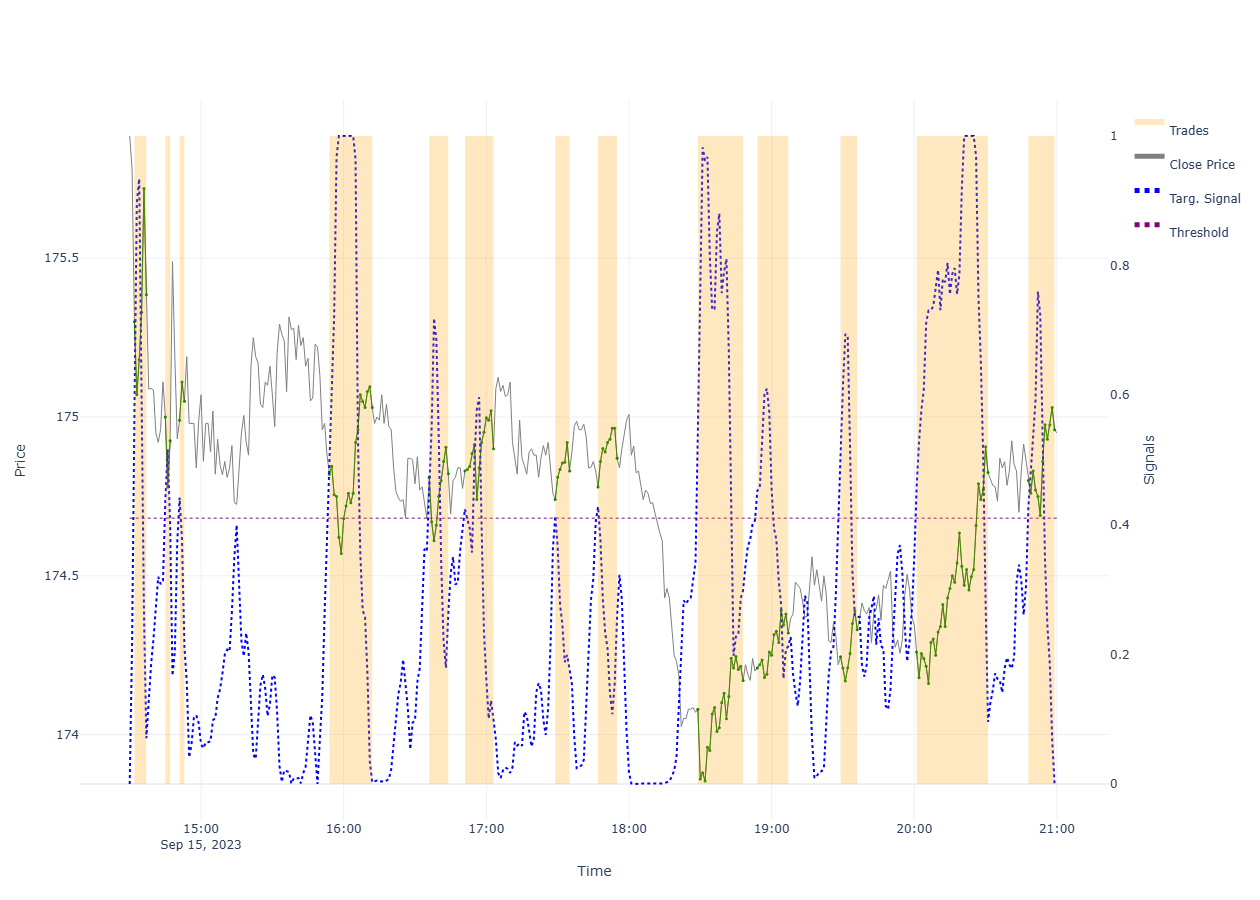


* Performance for 2023-09-15 *
  Buy & Hold Return ($): -1.198
  Strategy Return ($): -1.856
  Trades Returns ($): [-0.179, -0.338, -0.203, -0.052, -0.252, -0.192, -0.171, -0.173, -0.171, -0.152, -0.176, 0.303, -0.101]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


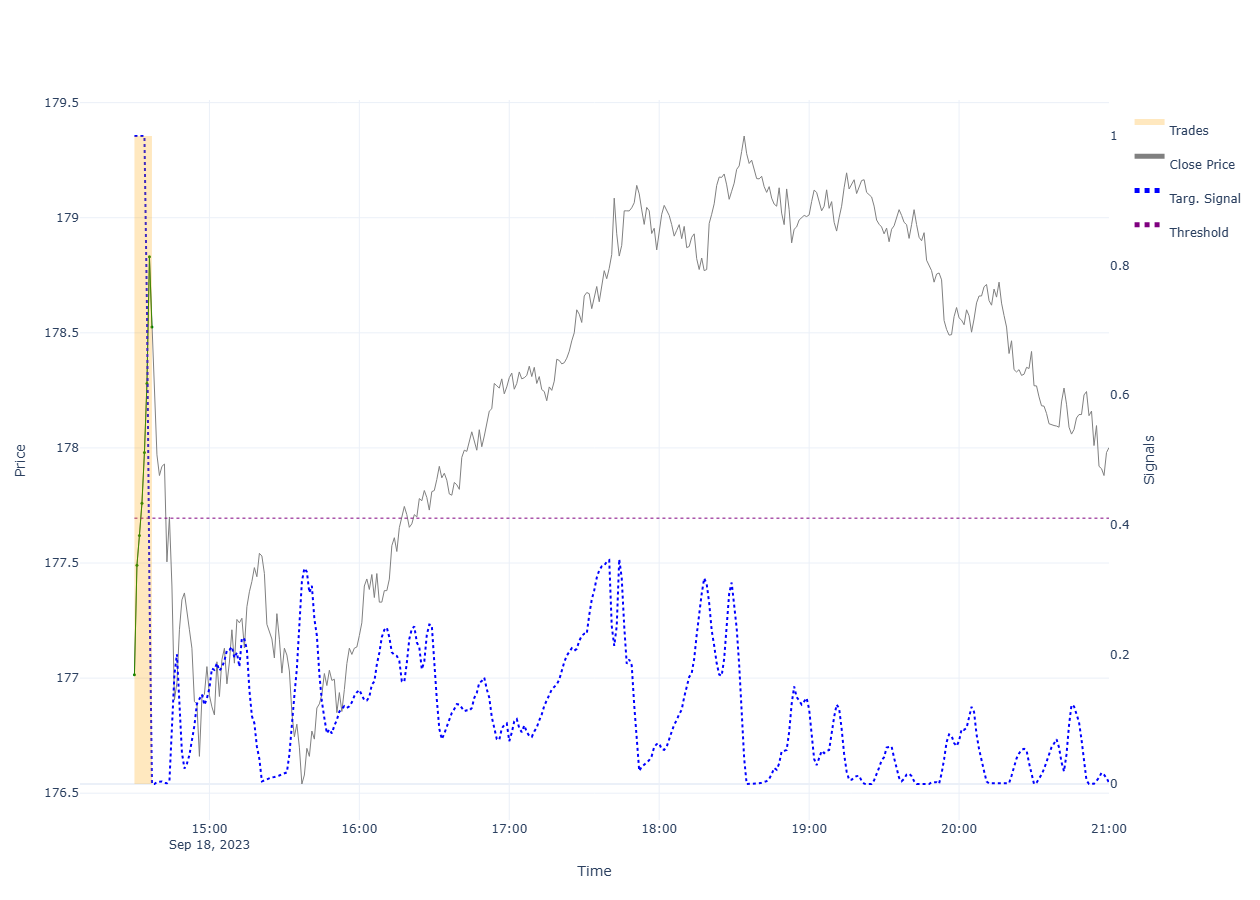


* Performance for 2023-09-18 *
  Buy & Hold Return ($): 0.72
  Strategy Return ($): 1.244
  Trades Returns ($): [1.244]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


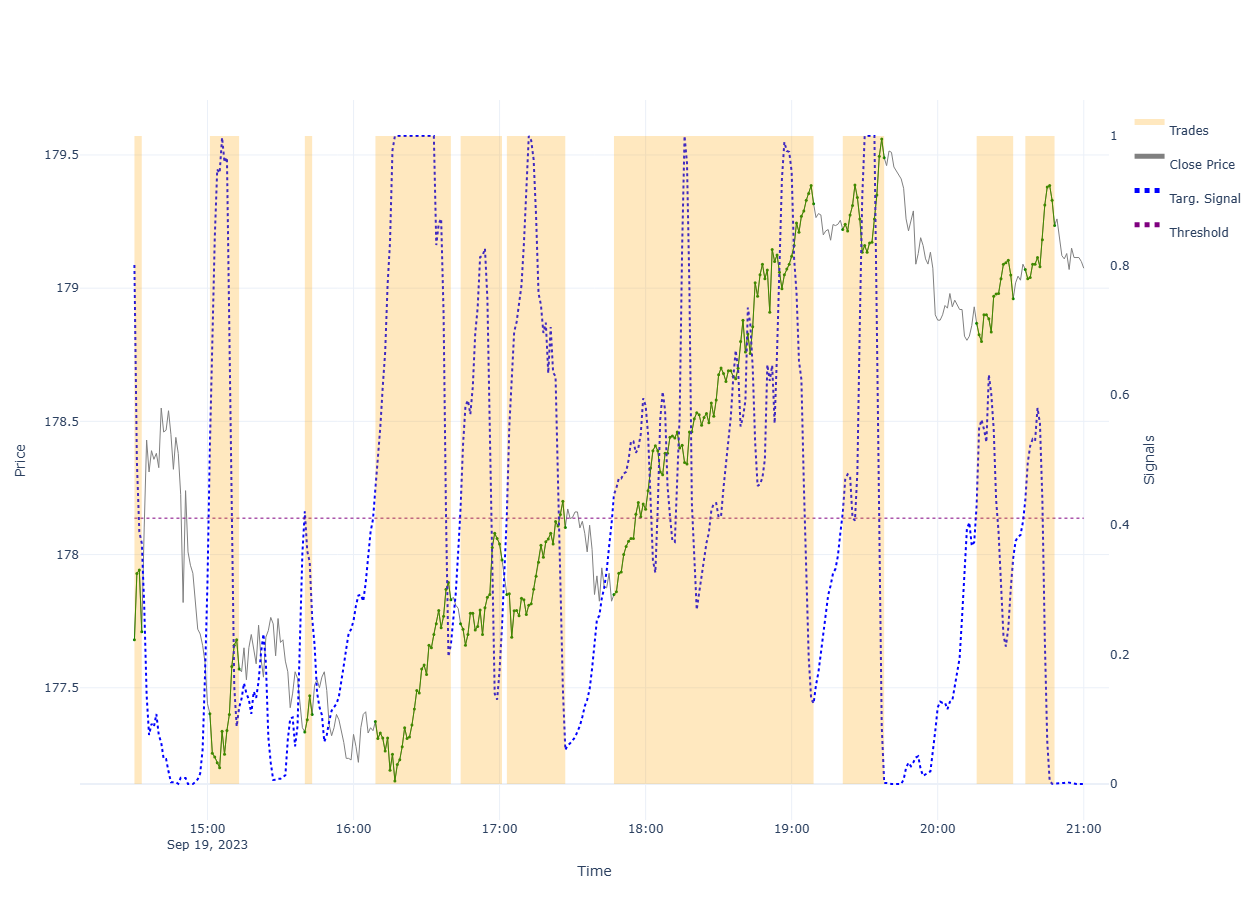


* Performance for 2023-09-19 *
  Buy & Hold Return ($): 1.127
  Strategy Return ($): 0.532
  Trades Returns ($): [-0.236, -0.099, -0.201, 0.19, -0.027, -0.014, 1.2, 0.002, -0.177, -0.104]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


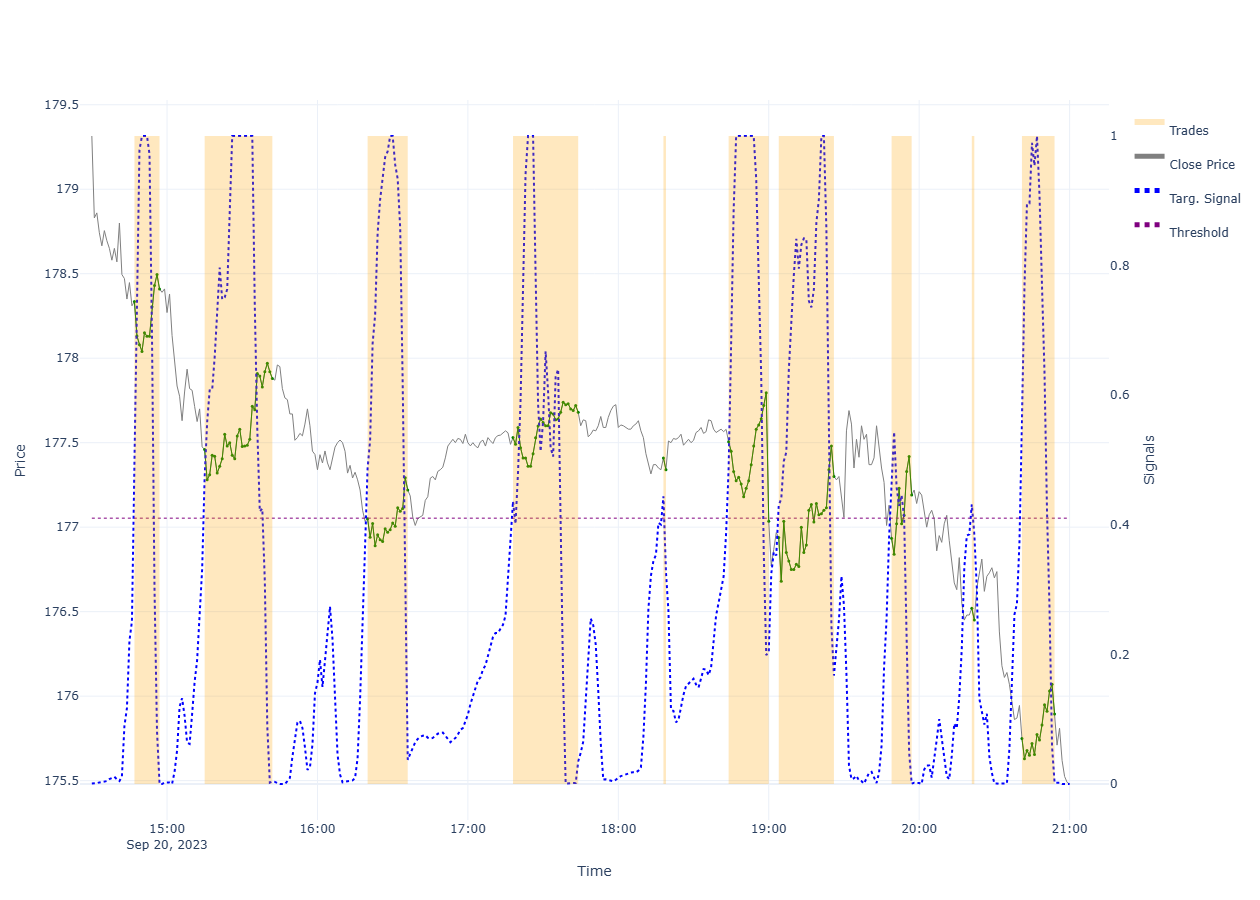


* Performance for 2023-09-20 *
  Buy & Hold Return ($): -4.101
  Strategy Return ($): -1.69
  Trades Returns ($): [-0.193, 0.153, -0.096, -0.117, -0.336, -0.735, 0.096, -0.011, -0.334, -0.118]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


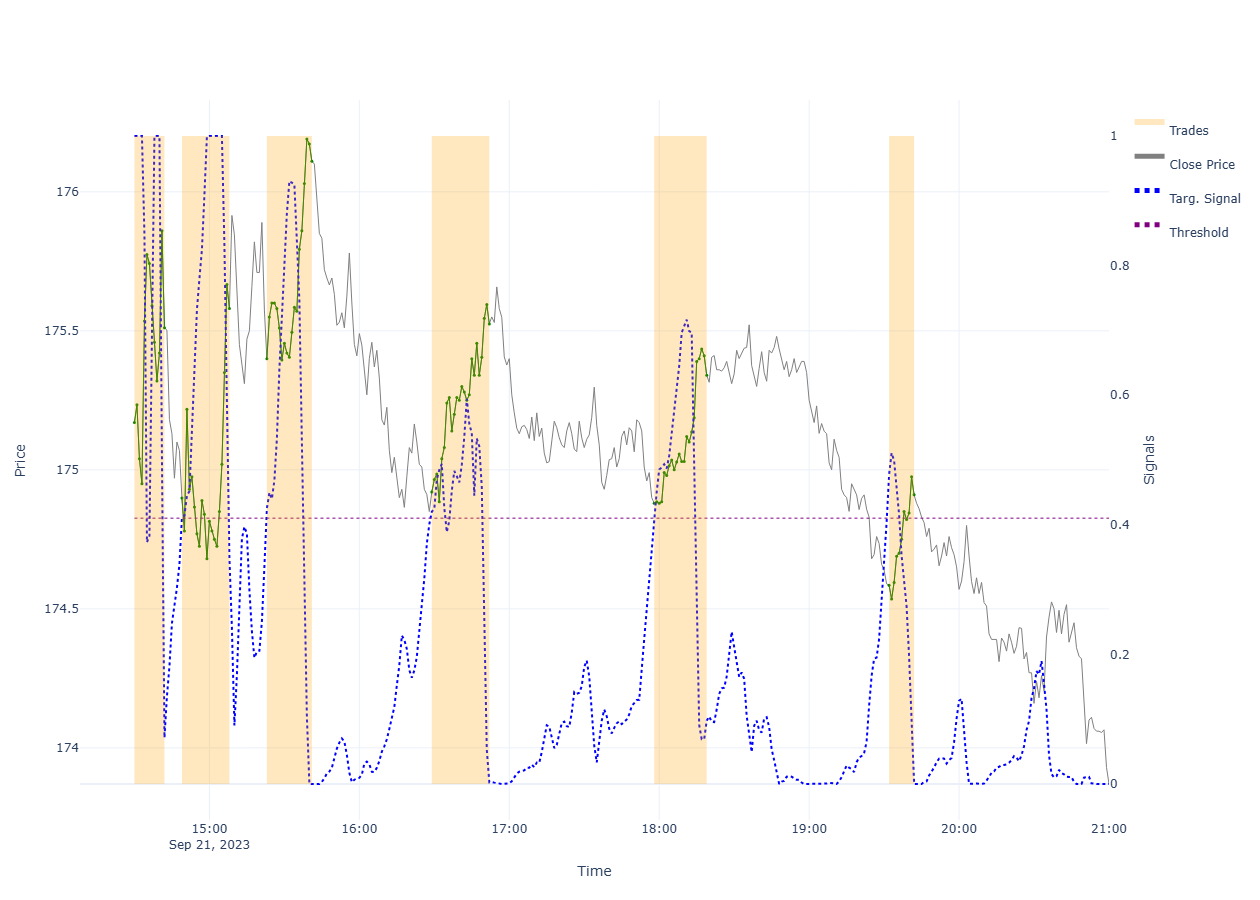


* Performance for 2023-09-21 *
  Buy & Hold Return ($): -1.562
  Strategy Return ($): 1.545
  Trades Returns ($): [0.079, 0.418, 0.446, 0.341, 0.198, 0.063]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


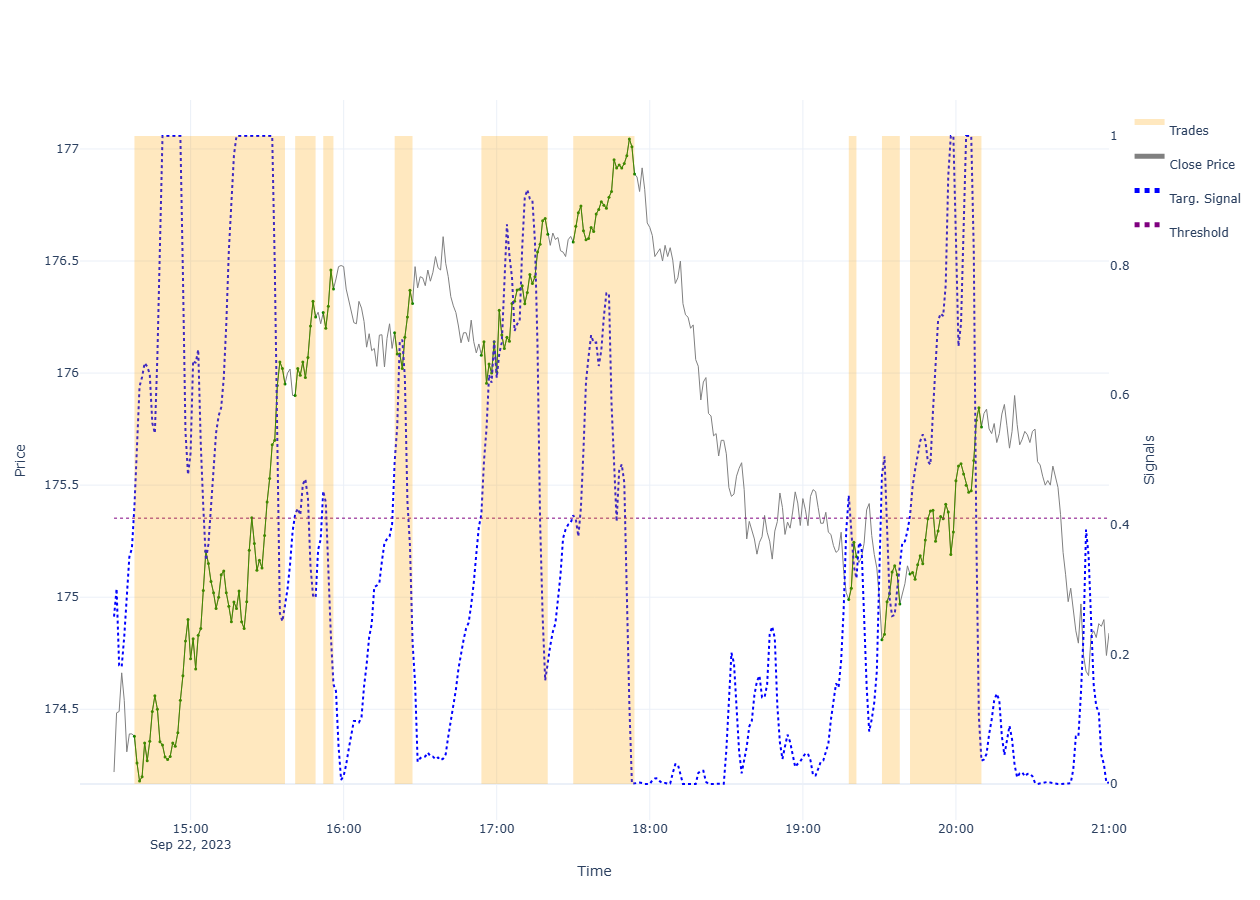


* Performance for 2023-09-22 *
  Buy & Hold Return ($): 0.358
  Strategy Return ($): 1.633
  Trades Returns ($): [1.309, 0.086, -0.159, -0.134, 0.275, 0.039, -0.072, -0.101, 0.393]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


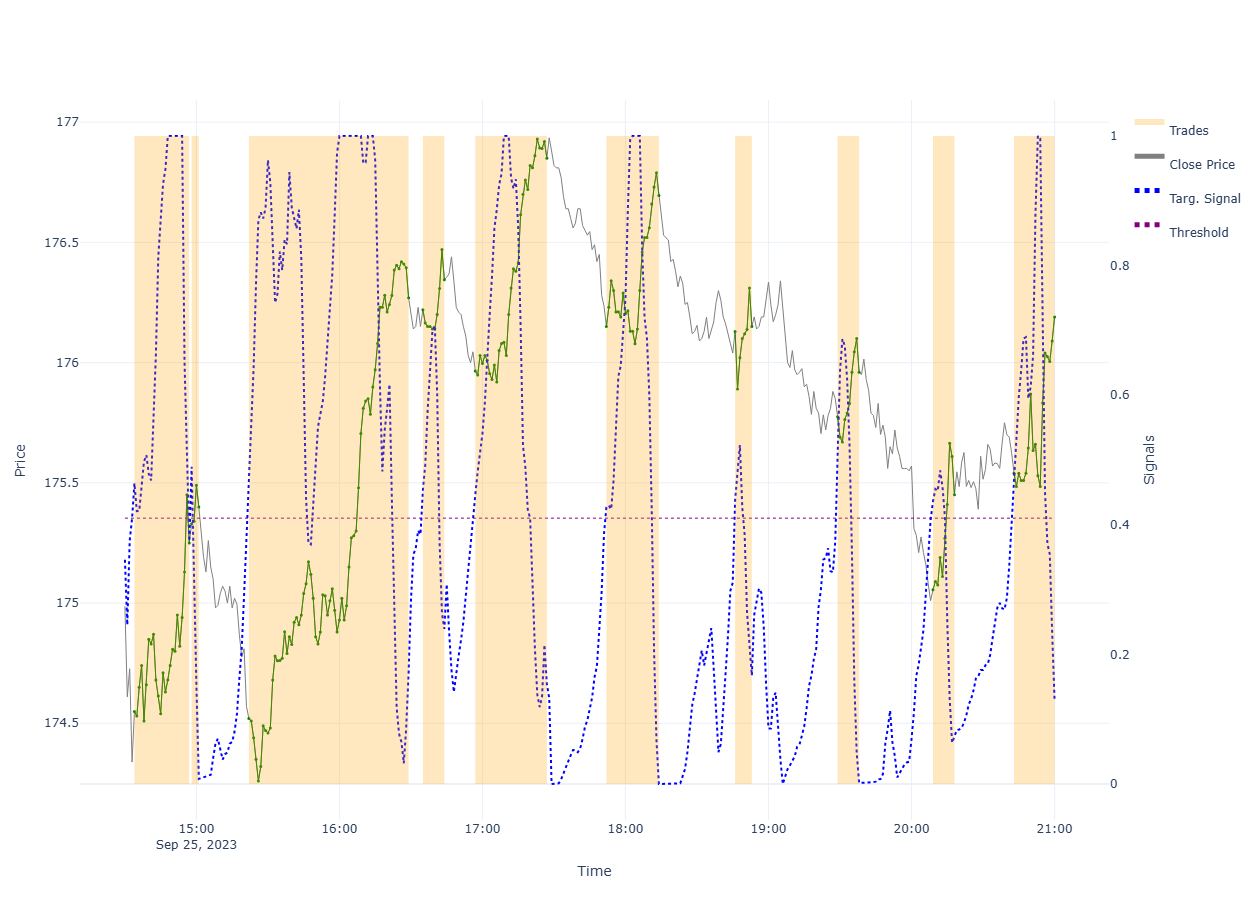


* Performance for 2023-09-25 *
  Buy & Hold Return ($): 0.94
  Strategy Return ($): 2.689
  Trades Returns ($): [0.438, -0.193, 1.486, -0.139, 0.62, 0.28, -0.243, -0.079, 0.131, 0.386]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


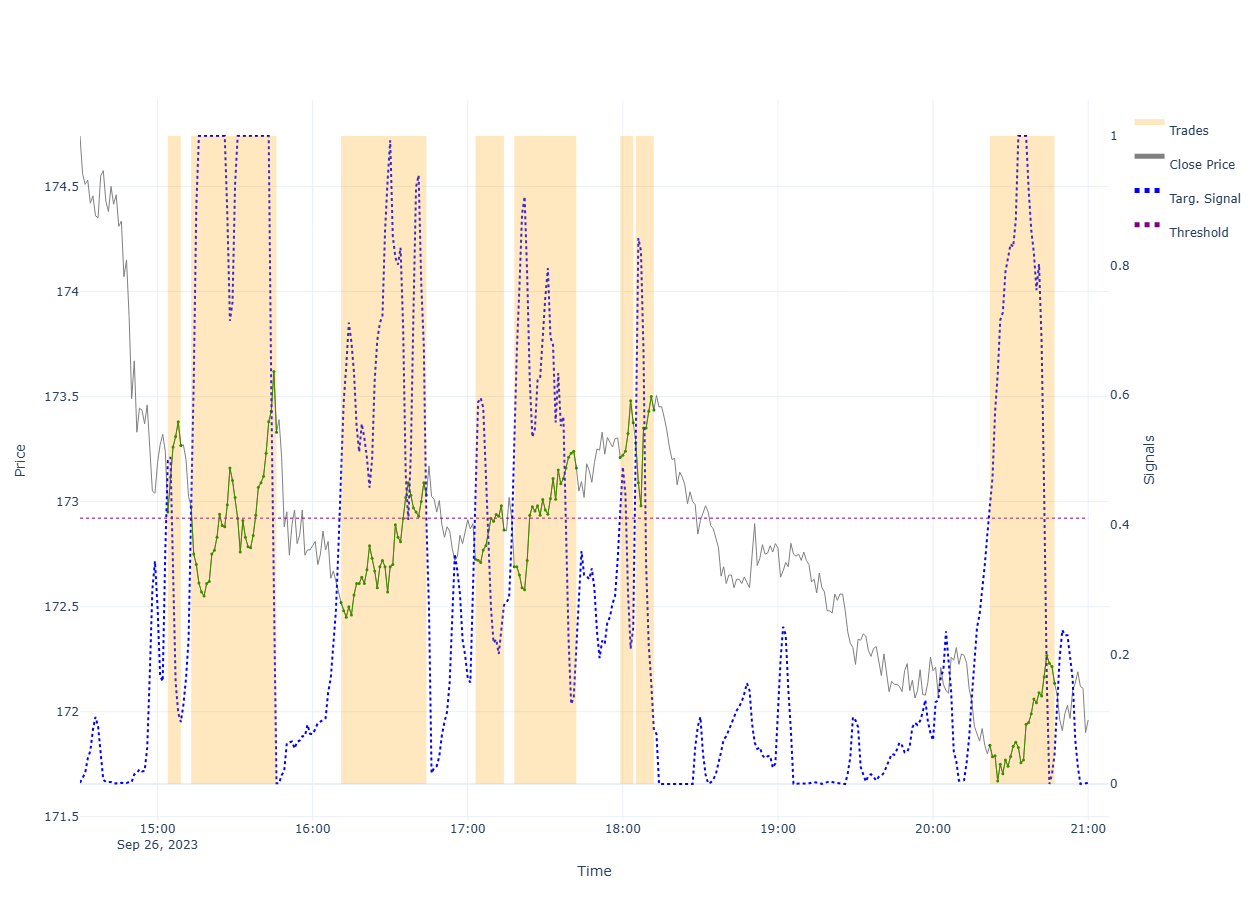


* Performance for 2023-09-26 *
  Buy & Hold Return ($): -3.04
  Strategy Return ($): 0.333
  Trades Returns ($): [0.057, 0.095, 0.252, -0.119, 0.211, -0.095, -0.104, 0.038]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


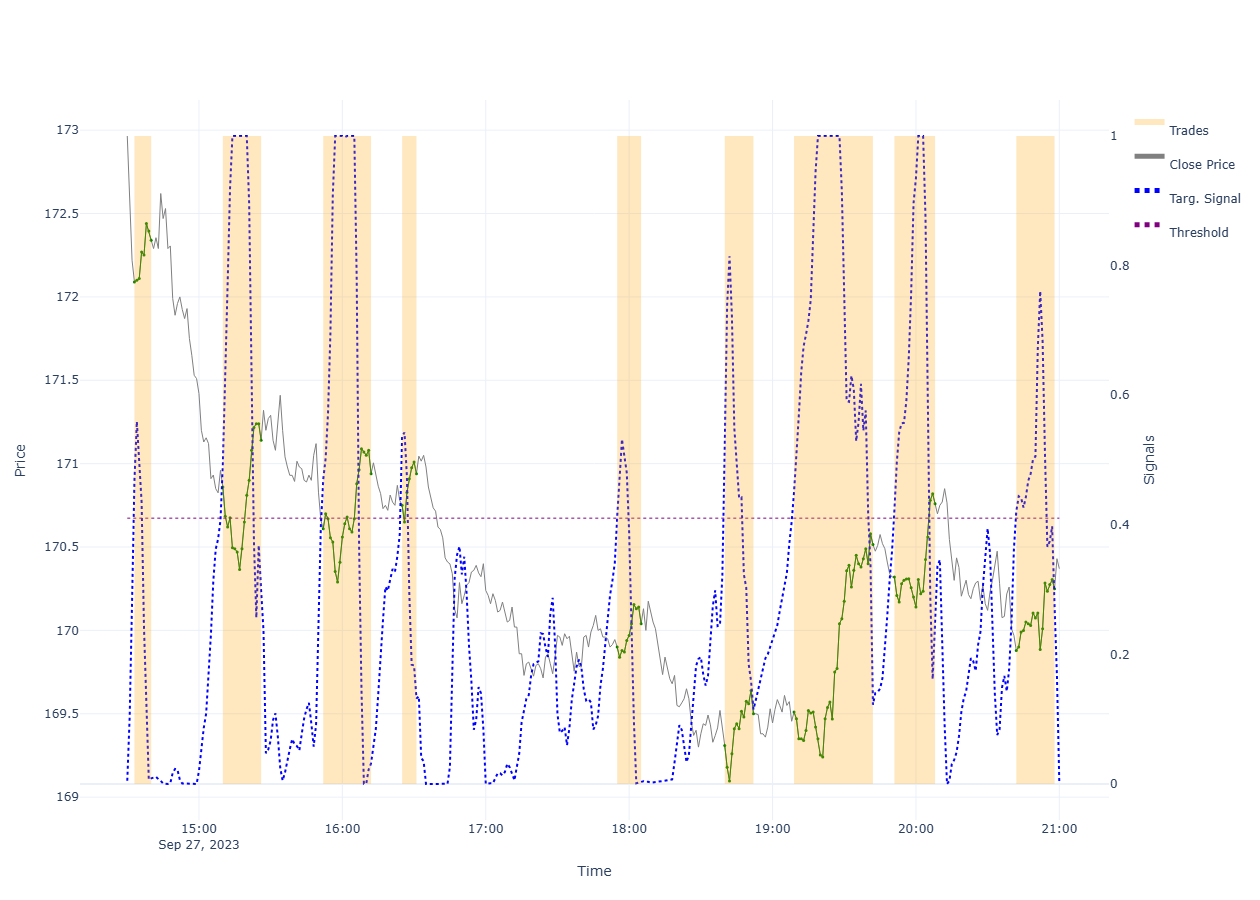


* Performance for 2023-09-27 *
  Buy & Hold Return ($): -2.852
  Strategy Return ($): 0.893
  Trades Returns ($): [-0.009, 0.024, 0.073, -0.067, -0.116, -0.064, 0.75, 0.184, 0.116]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


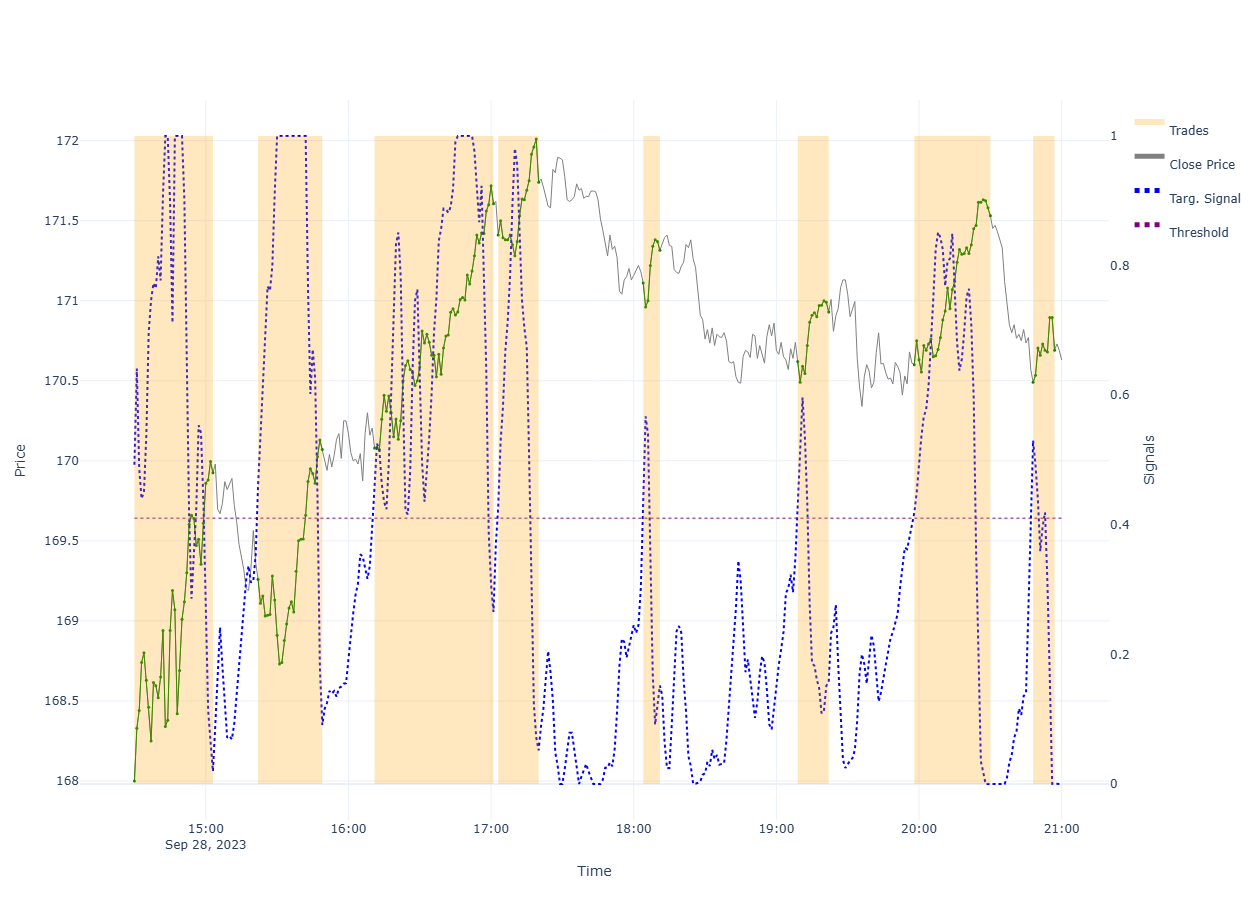


* Performance for 2023-09-28 *
  Buy & Hold Return ($): 2.376
  Strategy Return ($): 4.188
  Trades Returns ($): [1.671, 0.556, 1.268, 0.072, -0.051, 0.055, 0.673, -0.056]

---------------------------------------------------------------------------------------------------------------------------------------------------


=== Processing trading day 2023-09-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


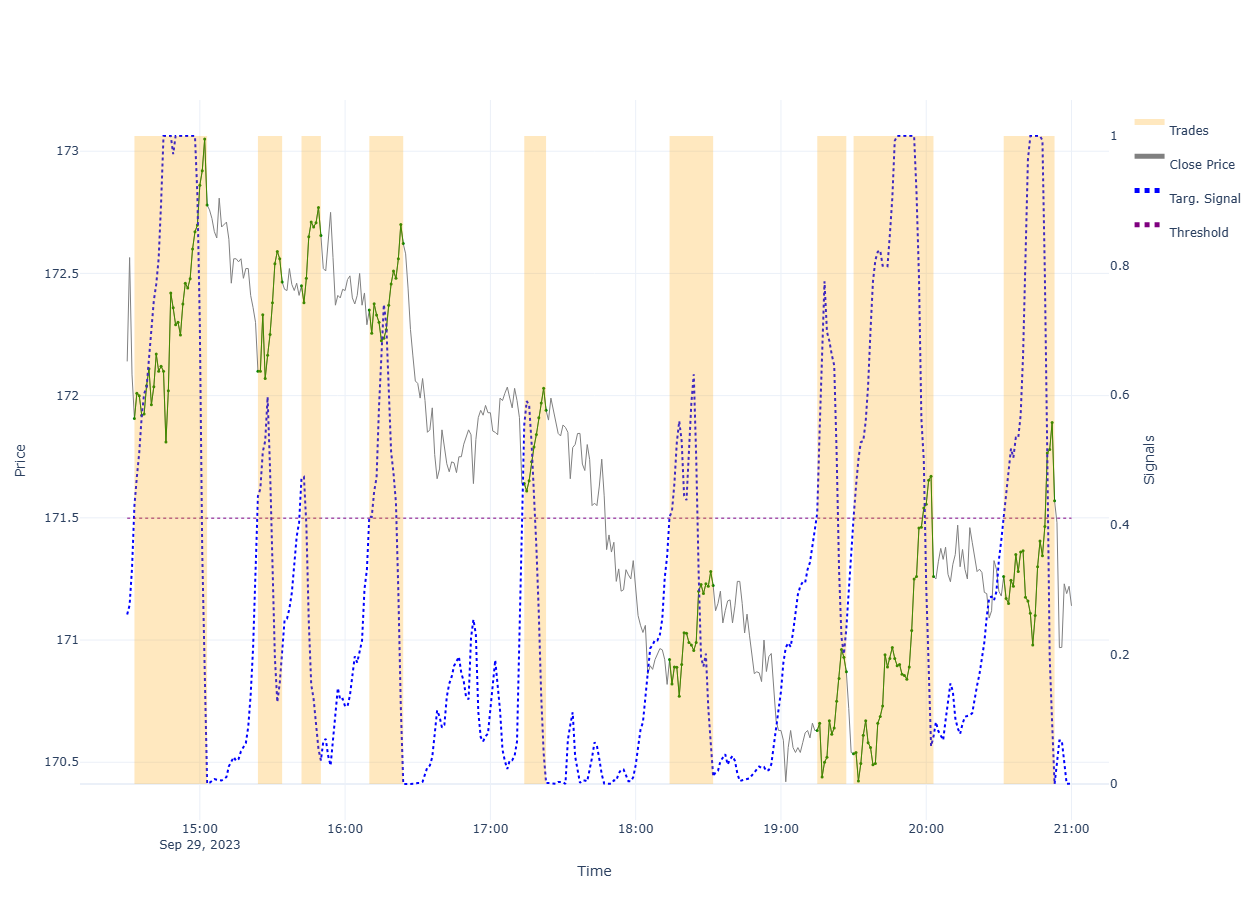


* Performance for 2023-09-29 *
  Buy & Hold Return ($): -1.258
  Strategy Return ($): 1.276
  Trades Returns ($): [0.616, 0.107, -0.053, 0.014, 0.043, 0.046, -0.015, 0.469, 0.053]

Overall Summary (2023-09-01 = 189.7672 → 2023-09-29 = 171.0116)

One-time buy&hold gain: -18.756
Buy & Hold – each day ($): -17.057
Strategy Return ($): 21.810
Trades Count: 173
Strategy return per trade: 0.126
Num. trading days: 20
Strategy return per trading day: 1.091


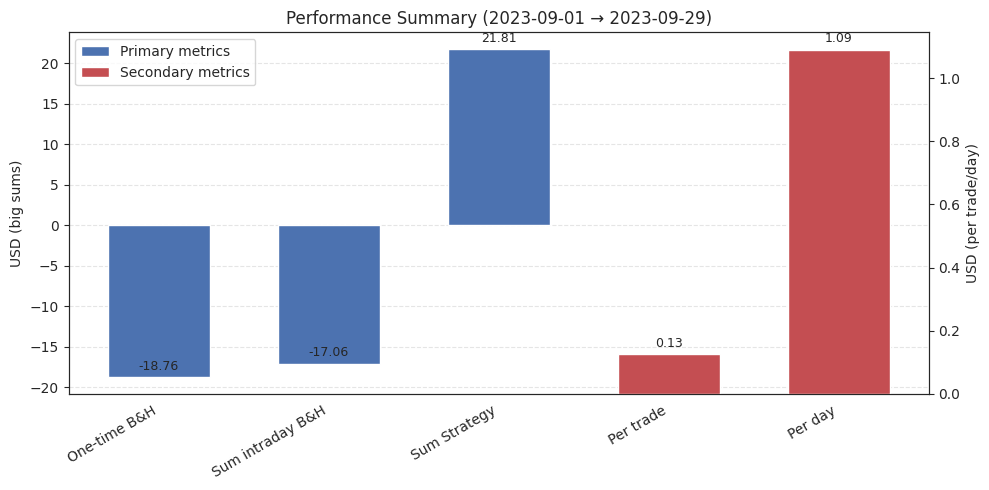

open    high      low   close      volume       ask  \
2023-09-01 09:00:00  188.330  188.54  188.150  188.32       204.0  188.4612   
2023-09-01 09:01:00  188.240  188.47  188.240  188.26        38.0  188.4012   
2023-09-01 09:02:00  188.330  188.36  188.300  188.32        26.0  188.4612   
2023-09-01 09:03:00  188.320  188.34  188.300  188.30        50.0  188.4412   
2023-09-01 09:04:00  188.340  188.35  188.160  188.16       863.0  188.3011   
...                      ...     ...      ...     ...         ...       ...   
2023-09-29 20:56:00  170.960  170.99  170.760  170.97    430618.0  171.0982   
2023-09-29 20:57:00  170.962  171.25  170.962  171.23    457904.0  171.3584   
2023-09-29 20:58:00  171.230  171.26  171.140  171.19    384412.0  171.3184   
2023-09-29 20:59:00  171.190  171.37  171.080  171.22   1036611.0  171.3484   
2023-09-29 21:00:00  171.210  171.29  171.130  171.14  19625629.0  171.2684   

                          bid    signal  signal_action  Position   Cash  \
2023-09-01 09:00:00  188.1788  0.039540              0         0  0.000   
2023-09-01 09:01:00  188.1188  0.029951              0         0  0.000   
2023-09-01 09:02:00  188.1788  0.038504              0         0  0.000   
2023-09-01 09:03:00  188.1588  0.086408              0         0  0.000   
2023-09-01 09:04:00  188.0189  0.159681              0         0  0.000   
...                       ...       ...            ...       ...    ...   
2023-09-29 20:56:00  170.8418  0.067268              0         0  1.276   
2023-09-29 20:57:00  171.1016  0.035189              0         0  1.276   
2023-09-29 20:58:00  171.0616  0.000335              0         0  1.276   
2023-09-29 20:59:00  171.0916  0.000335              0         0  1.276   
2023-09-29 21:00:00  171.0116  0.000000              0         0  1.276   

                     NetValue    Action  TradedAmount  BuyHoldEarning  \
2023-09-01 09:00:00     0.000  No trade             0           0.000   
2023-09-01 09:01:00     0.000  No trade             0           0.000   
2023-09-01 09:02:00     0.000  No trade             0           0.000   
2023-09-01 09:03:00     0.000  No trade             0           0.000   
2023-09-01 09:04:00     0.000  No trade             0           0.000   
...                       ...       ...           ...             ...   
2023-09-29 20:56:00     1.276      Hold             0          -1.427   
2023-09-29 20:57:00     1.276      Hold             0          -1.168   
2023-09-29 20:58:00     1.276      Hold             0          -1.208   
2023-09-29 20:59:00     1.276      Hold             0          -1.178   
2023-09-29 21:00:00     1.276  No trade             0          -1.258   

                     StrategyEarning  EarningDiff  
2023-09-01 09:00:00            0.000        0.000  
2023-09-01 09:01:00            0.000        0.000  
2023-09-01 09:02:00            0.000        0.000  
2023-09-01 09:03:00            0.000        0.000  
2023-09-01 09:04:00            0.000        0.000  
...                              ...          ...  
2023-09-29 20:56:00            1.276        2.703  
2023-09-29 20:57:00            1.276        2.444  
2023-09-29 20:58:00            1.276        2.484  
2023-09-29 20:59:00            1.276        2.454  
2023-09-29 21:00:00            1.276        2.534  

[14420 rows x 17 columns]

In [5]:
print('best_optuna_value:', params.best_optuna_value)
print('best_optuna_params:', params.best_optuna_params)

df_fin = saveDF_checkDAY(
                        df=df,
                        best_optuna_params=params.best_optuna_params
                        )

df_fin

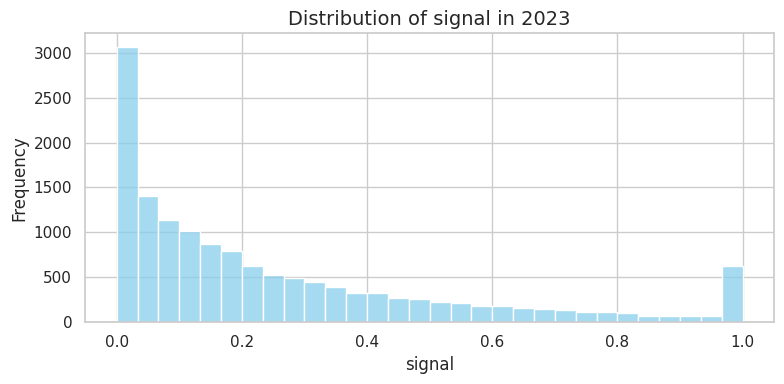

signal_min  signal_max  signal_mean  signal_median  close_return
2023-09         0.0         1.0     0.253472        0.15515      0.130625

In [6]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
